In [2]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None 
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)
import matplotlib.pyplot 
import Bio
#Neighbour Join Tree
import pandas as pd
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
import matplotlib.pyplot as plt
import Bio.Phylo as Phylo
import os
import Bio.Phylo as Phylo
import warnings

In [3]:
# pd.set_option('display.max_rows', None)
df_weekly_sum = pd.read_csv('dpgr_gisaid_continents.csv')
print(df_weekly_sum.head())

  Clade                   Date       Location  Freq
0    GH  2019-12-30/2020-01-05         Africa    24
1    GH  2019-12-30/2020-01-05           Asia    98
2    GH  2019-12-30/2020-01-05         Europe   580
3    GH  2019-12-30/2020-01-05  North America   460
4    GH  2019-12-30/2020-01-05        Oceania    56


In [4]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['G','GH','GK','GR','GRA','GRY','GV','L','O','S','V']
# VOC = ['Delta', 'Omicron']
VOC = ['GH','GK','GR','GRA','GRY']

clade_input = VOC    ####

# # #function to generate distance matrix based on quarter, year, and continent
# def create_distance_matrix(df,quarter_continent, variant_choice_set):
#     tmp = df['Variant'].str.split('vs', expand=True)
#     clade_list = tmp[0].unique()
#     clade_list = [variant for variant in clade_list if variant in variant_choice_set]
#     distance_matrix = pd.DataFrame(index = clade_list)
#     distance_matrix[clade_list] = np.nan
#     #fill in distance matrix
#     for i in clade_list:
#         for j in clade_list:
#             if i == j:
#                 distance_matrix.loc[i,j] = 0
#             else:
#                 distance_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#                 distance_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#     return distance_matrix

# #distance matrix where you can select which variants to compare 
# def create_distance_matrix(df, quarter_continent, variant_choice_set):
#     clade_list = set()
#     for variant in df['Variant']:
#         clades = variant.split(' vs ')
#         clade_list.update(clades)
# #         print(clade_list)

    
#     clade_list = sorted(clade_list)
#     clade_list = [variant for variant in clade_list if variant in variant_choice_set] #
#     distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    
#     distance_matrix.fillna(0, inplace=True)

#     for i in clade_list:
#         for j in clade_list:
#             if i != j:
#                 variant_1 = f"{i} vs {j}"
#                 variant_2 = f"{j} vs {i}"
#                 slope_1 = df.loc[df['Variant'] == variant_1, 'Slope']
#                 slope_2 = df.loc[df['Variant'] == variant_2, 'Slope']
#                 slope = slope_1.iloc[0] if not slope_1.empty else slope_2.iloc[0]
#                 distance_matrix.loc[i, j] = abs(slope)

#     return distance_matrix
# #     print(distance_matrix)

#updated distance matrix which resolves the symmetricity issue
def create_distance_matrix(df, quarter_continent, variant_choice_set):
    clade_list = set()
    for variant in df['Clade']:
        clades = variant.split(' vs ')
        clade_list.update(clades)
#         print(clade_list)

    #this code snippet orders the clade lista ccording to this order : order = ['GRY', 'GH', 'GK', 'GRA', 'GR']
    #which helps to create a distance matrix of our desired order 
    order = ['GRY', 'GH', 'GK', 'GRA', 'GR']

    clade_list = sorted(clade_list, key=lambda x: order.index(x))

#     clade_list = sorted(clade_list)
#     print(f"sorted_clade_list: {clade_list}")
    clade_list = [variant for variant in clade_list if variant in variant_choice_set] #
#     clade_list = clade_list.reverse()
#     print(clade_list)
    distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    
    distance_matrix.fillna(0, inplace=True)

    for i in clade_list:
        for j in clade_list:
            if i != j:
                variant_1 = f"{i} vs {j}"
                variant_2 = f"{j} vs {i}"
                slope_1 = df.loc[df['Clade'] == variant_1, 'Slope']
                slope_2 = df.loc[df['Clade'] == variant_2, 'Slope']
                slope = slope_1.iloc[0] if not slope_1.empty else slope_2.iloc[0]
                distance_matrix.loc[i, j] = abs(slope)
                distance_matrix.loc[j, i] = abs(slope)  # Add this line to ensure symmetry

    return distance_matrix
#     print(distance_matrix)


# # #function to generate difference matrix based on quarter, year, and continent
# def create_difference_matrix(df,quarter_continent, variant_choice_set):
#     tmp = df['Variant'].str.split('vs', expand=True)
#     clade_list = tmp[0].unique()
#     clade_list = [variant for variant in clade_list if variant in variant_choice_set] #
#     difference_matrix = pd.DataFrame(index = clade_list)
#     difference_matrix[clade_list] = np.nan
#     #fill in difference matrix
#     for i in clade_list:
#         for j in clade_list:
#             if i == j:
#                 difference_matrix.loc[i,j] = 0
#             else:
#                 difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#                 difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#     #if row_vs_col is a negative value, make it negative in difference matrix
#     for i,v in difference_matrix.iterrows():
#         for j in difference_matrix:
#             if i != j:
#                 if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
#                     difference_matrix.loc[i,j] *= -1
#     return difference_matrix



# #difference matrix where you can select which variants to compare 
# def create_difference_matrix(df, quarter_continent, variant_choice_set):
#     clade_list = set()
#     for variant in df['Clade']:
#         clades = variant.split(' vs ')
#         clade_list.update(clades)
# #         print(clade_list)

    
#     clade_list = sorted(clade_list)
# #     print(clade_list)
#     clade_list = [variant for variant in clade_list if variant in variant_choice_set] #
# #     clade_list = clade_list.reverse()
#     difference_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    
#     difference_matrix.fillna(0, inplace=True)

#     for i in clade_list:
#         for j in clade_list:
#             if i != j:
#                 variant_1 = f"{i} vs {j}"
#                 variant_2 = f"{j} vs {i}"
#                 slope_1 = df.loc[df['Clade'] == variant_1, 'Slope']
#                 slope_2 = df.loc[df['Clade'] == variant_2, 'Slope']
#                 slope = slope_1.iloc[0] if not slope_1.empty else slope_2.iloc[0]
#                 difference_matrix.loc[i, j] = abs(slope)
#                 difference_matrix.loc[j, i] = abs(slope)  # Add this line to ensure symmetry

#     #if row_vs_col is a negative value, make it negative in difference matrix
#     for i,v in difference_matrix.iterrows():
#         for j in difference_matrix:
#             if i != j:
#                 if (df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
#                     difference_matrix.loc[i,j] *= -1
#     return difference_matrix

def create_difference_matrix(distance_matrix):
    difference_matrix = distance_matrix.copy()

    # Iterate over the rows and columns of the difference_matrix
    for i, row in difference_matrix.iterrows():
        for j in difference_matrix.columns:
            if i != j:
                # Check if the row_vs_col value is negative
                if distance_matrix.loc[i, j] < 0:
                    # Set values above the main diagonal to the negative value
                    difference_matrix.loc[i, j] = -abs(difference_matrix.loc[i, j])
                    difference_matrix.loc[j, i] = abs(difference_matrix.loc[i, j])
                else:
                    # Set values below the main diagonal to the positive value
                    difference_matrix.loc[i, j] = abs(difference_matrix.loc[i, j])
                    difference_matrix.loc[j, i] = -abs(difference_matrix.loc[i, j])

    return difference_matrix

#function to calculate the log transformed ratio of two clades
def transform_ratio(clade_1, clade_2):
    return np.log10(clade_1/clade_2)

def time_frame(df, start_date, end_date):  #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    for i in dataframe.columns.tolist():
        if dataframe[i].isnull().all():
            dataframe = dataframe.drop(i, axis=1)
    return dataframe


# def time_frame_no_cumsum(df,time_window):
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     return dataframe

def time_frame_no_cumsum(df,start_date, end_date): #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, pairwise_fitness):
#     print(day)
#     print(pairwise_fitness)
    par = np.polyfit(day, pairwise_fitness, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]

    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i,b=j)] = df.apply(lambda row : 
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

### *Use the automation mine function to create the distance matrix in variant choice set for specific time window*

In [5]:
# This function finds the distance matrix among all the clades 

def automation_mine(country, dataset, start, end, variant_choice_set):
    
    df_weekly = dataset[dataset['Location'] == country]
    
#     # Set the option to display all rows
#     pd.set_option('display.max_rows', None)
#     print(df_weekly)
    
#     print(df_weekly.head())
    #print unique variants available in the target location
    print(f"Vaiants available at {country} : {df_weekly['Clade'].unique()}")
    #pivot dataframe so that index is date and columns are clades
    df_weekly = df_weekly.pivot(index = 'Date', columns = 'Clade', values = 'Freq')
    df_weekly = df_weekly.reset_index()
    

    df_weekly['Collection date'] = np.random.randint(1,6,df_weekly.shape[0])

    #split date column so we can retrieve month and year
    tmp = df_weekly['Date'].str.rsplit('-',n=3, expand = True)
    tmp.columns = ['0','1','2','3']

    #collection date column contains month and year of each week 
    df_weekly['Collection date'] = tmp['0']
    cols = df_weekly.columns.tolist()
    cols = cols[0:1] + cols[-1:] + cols[1:-1]
    df_weekly = df_weekly[cols]
#     print(f"df_weekly :\n {df_weekly.head}")
#     print(f"df_weekly : \n {df_weekly.columns}")
           
    #specify time frame to analyze
    df_sum = time_frame(df_weekly, start, end)
    # df_sum.to_csv(country+"df_sum"+r'.csv')
#     print(f"df_sum :\n {df_sum}")
    #calculate log comparisons at each week
    df_ = clade_comparisons(df_sum)
#     print(f" df_ : \n{df_}")
    # df_.to_csv(country+'_clade_comparison')
    df_['days'] -= df_['days'].iloc[0]
#     print(f"df_ :\n {df_}")
#     print(f"df_ :\n {df_.columns}")
    

    #Make the combinations of the variant choice set
    combinations = []

    # Append 'Omicron vs Delta'
    combination1 = ' vs '.join(variant_choice_set)
    combinations.append(combination1)
#     print(combinations)

    # Append 'Delta vs Omicron'
    combination2 = ' vs '.join(sorted(list(variant_choice_set), reverse=True))
    combinations.append(combination2)
#     print(combinations)

    #calculate slopes, have to disregard nans
    df_slopes = pd.DataFrame()
    cols = df_.columns.to_list()
#     print(f"df_ columns : {cols}")
    df_slopes['Clade'] = cols[3:]
#     print(f"df_slopes:\n {df_slopes}")
    slopes = []
    for i,v in enumerate(df_.iloc[:,3:]):
#         tmp = df_[~df_.iloc[:,i+3].isnull()] ##issue (it chooses columns using the index)
        tmp = df_[df_.loc[:, df_.columns.isin(combinations)].notnull().any(axis=1)] #it chooses the columns that are given in the variant_choice set
        tmp['pseudo_time'] = np.array(range(0, tmp.shape[0] ))*7
#         print(f"tmp :\n {tmp}")
        slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp.iloc[0:len(tmp),i+3]))
#         slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp[v])) 
        #print(len(slopes))
#         print(df_slopes)
#     print(f"tmp :\n {tmp}")
#     print(f"Slopes: {slopes}")
    df_slopes['Slope'] = slopes
#     print(df_slopes)
    df_slopes = pd.DataFrame(df_slopes)   #changed
    
#     dist_mat = create_distance_matrix(df_slopes,'Slope')
#     # dist_mat.to_csv(country+"_dist_mat_WHO"+r'.csv')
#     print(f"distance matrix :\n {dist_mat}")

#     #define the file path
#     file_path = f'/scr/mjpantho/Pantho_differential_fitness/Distance_matrix_who/{country + "_" + start + "_" + end + "_dist_mat_who_labels"}.csv'

    dist_mat = create_distance_matrix(df_slopes, 'Slope', variant_choice_set)
#     dist_mat.to_csv(file_path, index=True)
    print(f"Diatance matrix: \n {dist_mat}")
    
    dist_mat = create_distance_matrix(df_slopes, 'Slope', variant_choice_set)
    file_name = f"{country}_{start}_{end}_gisaid_dist_mat.csv"
    directory = "/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path = os.path.join(directory, file_name)
    dist_mat.to_csv(file_path, index=True)
    if os.path.isfile(file_path):
        print(f"Distance matrix saved at: {file_path}")
    else:
        print("Error: Failed to save the distance matrix.")


#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_regression_plots/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)
    
#     dif_mat = create_difference_matrix(df_slopes,'Slope')
#     # dif_mat.to_csv(country+"_dif_mat_WHO"+r'.csv')
#     # print(f"difference matrix :\n {dif_mat}")

#     #Plot distance matrix as clustermap
#     sns.set(rc = {'figure.figsize':(10, 20)}, font_scale = 1.8)

#     #create distance array from distance matrix
#     distance_array = ssd.squareform(dist_mat) 

#     #create linkage object
#     distance_linkage = hierarchy.linkage(distance_array)
#     print(distance_array.shape)
#     print(dist_mat.shape)

#     #display clustermap
#     g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
#                         cmap = 'coolwarm',vmin=-.023,vmax=0.023, cbar_pos=(0.971, 0.087, .03, 0.7))                     
#     # g.fig.set_size_inches(10, 10)
#     # plt.savefig(country+"_clustermap_WHO"+'.jpg', dpi = 300, bbox_inches='tight')
#     return g

## North America

In [6]:
# pd.set_option('display.max_rows', None)
print(df_weekly_sum[df_weekly_sum['Location'] == 'North America'])

     Clade                   Date       Location  Freq
3       GH  2019-12-30/2020-01-05  North America   460
9       GH  2020-01-13/2020-01-19  North America     1
10      GH  2020-01-20/2020-01-26  North America     4
13      GH  2020-01-27/2020-02-02  North America     5
16      GH  2020-02-03/2020-02-09  North America     1
...    ...                    ...            ...   ...
2484   GRY  2022-02-07/2022-02-13  North America     1
2486   GRY  2022-02-21/2022-02-27  North America     1
2488   GRY  2022-03-07/2022-03-13  North America     1
2489   GRY  2022-03-14/2022-03-20  North America     1
2492   GRY  2022-04-25/2022-05-01  North America     1

[503 rows x 4 columns]


In [7]:
# #automation function finds the diatance matrix
automation_mine('North America', df_weekly_sum, start = '2020-12', end = '2021-01', variant_choice_set= {'GRY', 'GH'})

Vaiants available at North America : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2020-12', '2021-01']
Diatance matrix: 
           GRY        GH
GRY  0.000000  0.033998
GH   0.033998  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/North America_2020-12_2021-01_gisaid_dist_mat.csv


In [8]:
# #automation function finds the diatance matrix
automation_mine('North America', df_weekly_sum, start = '2021-08', end = '2021-09', variant_choice_set= {'GH', 'GK'})

Vaiants available at North America : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2021-08', '2021-09']
Diatance matrix: 
           GH        GK
GH  0.000000  0.003963
GK  0.003963  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/North America_2021-08_2021-09_gisaid_dist_mat.csv


In [9]:
# #automation function finds the diatance matrix
automation_mine('North America', df_weekly_sum, start = '2022-03', end = '2022-05', variant_choice_set= {'GK', 'GRA'})

Vaiants available at North America : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2022-03', '2022-04', '2022-05']
Diatance matrix: 
            GK       GRA
GK   0.000000  0.009216
GRA  0.009216  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/North America_2022-03_2022-05_gisaid_dist_mat.csv


In [10]:
gry_gh_na = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/North America_2020-12_2021-01_gisaid_dist_mat.csv',
    index_col=0)
gry_gh_na

,GRY,GH
GRY,0.000000,0.033998
GH,0.033998,0.000000


In [11]:
gh_gk_na = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/North America_2021-08_2021-09_gisaid_dist_mat.csv',
    index_col= 0)
gh_gk_na

,GH,GK
GH,0.000000,0.003963
GK,0.003963,0.000000


In [12]:
gk_gra_na = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/North America_2022-03_2022-05_gisaid_dist_mat.csv',
    index_col=0)
gk_gra_na

,GK,GRA
GK,0.000000,0.009216
GRA,0.009216,0.000000


### *Combine the distance matrices and plot the heatmap for getting the combined distance matrix for all the variants*

In [15]:
def heatmaps_from_combined_dist_map(clade_list, df1, df2, df3, location): #pass dataframe in a sorted order
    # create an empty dataframe
#     clade_list = sorted(clade_list)

    #this code snippet orders the clade list ccording to this order : order = ['GRY', 'GH', 'GK', 'GRA', 'GR']
    #which helps to create a distance matrix of our desired order 
    order = ['GRY', 'GH', 'GK', 'GRA', 'GR']

    clade_list = sorted(clade_list, key=lambda x: order.index(x))
    
    distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    distance_matrix.fillna(0, inplace=True)
#     print(distance_matrix)
    
    # assign values to the empty dataframe
    distance_matrix.iloc[0:2, 0:2] = pd.DataFrame(df1)
    distance_matrix.iloc[1:3, 1:3] = pd.DataFrame(df2)
    distance_matrix.iloc[2:4, 2:4] = pd.DataFrame(df3)
#     print(distance_matrix)
    
    distance_matrix.iloc[0,2] = distance_matrix.iloc[0,1] + distance_matrix.iloc[1,2]
    distance_matrix.iloc[0,3] = distance_matrix.iloc[0,2] + distance_matrix.iloc[3,2]
    distance_matrix.iloc[1,3] = distance_matrix.iloc[1,2] + distance_matrix.iloc[2,3]
    distance_matrix.iloc[2,0] = distance_matrix.iloc[0,2] 
    distance_matrix.iloc[3,0] = distance_matrix.iloc[0,3] 
    distance_matrix.iloc[3,1] = distance_matrix.iloc[1,3] 
    
    # Set the index of the dataframe to the first column
    distance_matrix.set_index(distance_matrix.columns, inplace=True)
    print(f"Distance Matrix :\n {distance_matrix}")
    
    #export the combined distance matrix
    #export the distance matrix
    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/"

    
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, location + "_continent_combined_distance_matrix_for_gisaid_labels.csv")
    print(f"Combined distance matrix saved at : {filename}")
    distance_matrix.to_csv(filename, index=False)

    
    dif_mat = create_difference_matrix(distance_matrix)
    # dif_mat.to_csv(country+"_dif_mat_WHO"+r'.csv')
    print(f"difference matrix :\n {dif_mat}")
    
    #Plot distance matrix as clustermap
    sns.set(rc={'figure.figsize': (2, 2)}, font_scale=1.2)  # Adjust the figsize as per your preference

    #create distance array from distance matrix
    distance_array = ssd.squareform(distance_matrix) 

    #create linkage object
    distance_linkage = hierarchy.linkage(distance_array)
#     print(distance_array.shape)
#     print(dist_mat.shape)

    # Display clustermap
    # g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
    #                cmap='coolwarm', vmin=-.023, vmax=0.023, cbar_pos=(0.978, 0.174, .05, 0.57 ),figsize=(4, 4))
    
    # Display clustermap with annotations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
                           cmap='coolwarm', vmin=-0.023, vmax=0.023, cbar_pos=(0.969, 0.147, 0.04, 0.7),
                           annot=True, fmt='.3f', annot_kws={"size": 7}, figsize=(4.6, 4.6), dendrogram_ratio=0.102)
    
        # Adjust colorbar label size
        cax = g.cax
        cax.set_yticklabels(cax.get_yticklabels(), fontsize=7)

#***************************************************************************************************************************************
    #Put the labels compared in each cell as text
    # Get the x-axis and y-axis labels from the clustermap plot
    x_labels = [label.get_text() for label in g.ax_heatmap.get_xticklabels()]
    y_labels = [label.get_text() for label in g.ax_heatmap.get_yticklabels()]
    # Add annotated texts in the cells
    for i in range(dif_mat.shape[0]):
        for j in range(dif_mat.shape[1]):
            text = f"{x_labels[i]} Vs. {y_labels[j]}"
            # value = f"{dif_mat.iloc[i, j]:.3f}"
            text_x = g.ax_heatmap.get_xticks()[j]
            text_y = g.ax_heatmap.get_yticks()[i]
            g.ax_heatmap.text(text_x, text_y + 0.2, text, ha='center', va='center', fontsize=5.5, color='black')
            
#***************************************************************************************************************************************
    g.fig.suptitle(f'Clustermap of Variant of Concerns(GISAID labels) \nLocation: {location}', fontsize = 8.5, y = 1.05)

    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/combined_heatmaps_continents_GISAID_labels/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, location + "_gisaid_combined_heatmaps_continents.png")
    g.savefig(filename, dpi=300, bbox_inches="tight")
    return g

    
    '''
        This portion of code plots the step plot of progressive fitness growth 
        of the variants
    '''
    #*******************************************************************************************************************
#     #export the combined distance matrix
#     #export the distance matrix
#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Save the figure to the specified directory with DPI set to 300
#     filename = os.path.join(directory, location + "_combined_distance_matrix_for_who_labels.csv")
#     distance_matrix.to_csv(filename, index=False)
    
#     # Create a step plot
#     plt.figure(figsize=(3, 3))  # Set figure size to 3 by 3
#     plt.step(distance_matrix.index, distance_matrix.values[0], linewidth=1.5, color='red')

#     # Add labels and title
# #     plt.xlabel('Variants', fontsize=12)
#     plt.ylabel('Fitness Value', fontsize=12)
#     plt.title(f'Progressive fitness growth of Covid Variants\n Location: {location}', fontsize=12)

#     # Set the background color to white
#     plt.gca().set_facecolor('white')

#     # Add axis lines
#     plt.axhline(0, color='black', linewidth=0.5)
#     plt.axvline(-0.1, color='black', linewidth=0.5)
    
#     # Rotate x-axis labels
# #     plt.xticks(range(len(distance_matrix.index)), distance_matrix.index, rotation=90, fontsize=8)  # Adjust fontsize as needed
#     plt.xticks([])  # Remove x-axis tick labels
#     plt.yticks()

#     # Display the labels on the graph
#     categories = ['alpha', 'beta', 'delta', 'omicron']
#     x = range(len(categories))
#     values = distance_matrix.values[0][0:5]
#     print(values)
#     for i in range(len(categories)):
#         plt.text(x[i], values[i], f'{categories[i]}', ha='left', va='bottom')

# #     # Rotate x-axis labels
# #     plt.xticks(rotation=90)
# #     plt.yticks()

#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/figures_for_step_plot/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Save the figure to the specified directory with DPI set to 300
#     filename = os.path.join(directory, location + "_variant_step_plot.png")
#     plt.savefig(filename, dpi=300, bbox_inches="tight")
    
#     # Show the plot
#     plt.show()
    #*********************************************************************************************************************

Distance Matrix :
           GRY        GH        GK       GRA
GRY  0.000000  0.033998  0.037961  0.047177
GH   0.033998  0.000000  0.003963  0.013179
GK   0.037961  0.003963  0.000000  0.009216
GRA  0.047177  0.013179  0.009216  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/North America_continent_combined_distance_matrix_for_gisaid_labels.csv
difference matrix :
           GRY        GH        GK       GRA
GRY  0.000000 -0.033998 -0.037961 -0.047177
GH   0.033998  0.000000 -0.003963 -0.013179
GK   0.037961  0.003963  0.000000 -0.009216
GRA  0.047177  0.013179  0.009216  0.000000


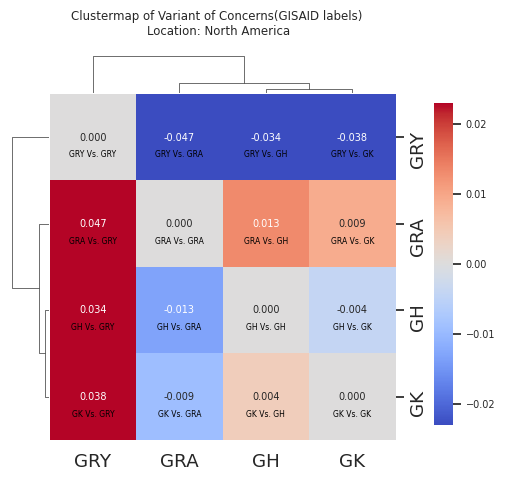

In [16]:
clustermap_obj_na = heatmaps_from_combined_dist_map(['GH', 'GRY', 'GK', 'GRA'],
                                                    gry_gh_na,
                                                    gh_gk_na,
                                                    gk_gra_na,
                                                    'North America')
combined_distance_matrix_na = pd.DataFrame(clustermap_obj_na.data)

## Europe

In [17]:
# pd.set_option('display.max_rows', None)
print(df_weekly_sum[df_weekly_sum['Location'] == 'Europe'])

     Clade                   Date Location  Freq
2       GH  2019-12-30/2020-01-05   Europe   580
7       GH  2020-01-06/2020-01-12   Europe     2
15      GH  2020-02-03/2020-02-09   Europe     2
18      GH  2020-02-10/2020-02-16   Europe     2
21      GH  2020-02-17/2020-02-23   Europe     4
...    ...                    ...      ...   ...
2485   GRY  2022-02-14/2022-02-20   Europe     1
2487   GRY  2022-03-07/2022-03-13   Europe     2
2490   GRY  2022-03-21/2022-03-27   Europe     1
2491   GRY  2022-03-28/2022-04-03   Europe     1
2493   GRY  2022-05-02/2022-05-08   Europe     1

[479 rows x 4 columns]


In [18]:
# #automation function finds the diatance matrix
automation_mine('Europe', df_weekly_sum, start = '2020-11', end = '2020-12', variant_choice_set= {'GRY', 'GH'})

Vaiants available at Europe : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2020-11', '2020-12']
Diatance matrix: 
           GRY        GH
GRY  0.000000  0.018372
GH   0.018372  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_2020-11_2020-12_gisaid_dist_mat.csv


In [19]:
# #automation function finds the diatance matrix
automation_mine('Europe', df_weekly_sum, start = '2021-04', end = '2021-05', variant_choice_set= {'GH', 'GK'})

Vaiants available at Europe : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2021-04', '2021-05']
Diatance matrix: 
           GH        GK
GH  0.000000  0.031299
GK  0.031299  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_2021-04_2021-05_gisaid_dist_mat.csv


In [20]:
# #automation function finds the diatance matrix
automation_mine('Europe', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'GK', 'GRA'})

Vaiants available at Europe : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2021-11', '2021-12']
Diatance matrix: 
           GK      GRA
GK   0.00000  0.07276
GRA  0.07276  0.00000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_2021-11_2021-12_gisaid_dist_mat.csv


Distance Matrix :
           GRY        GH        GK       GRA
GRY  0.000000  0.018372  0.049671  0.122432
GH   0.018372  0.000000  0.031299  0.104060
GK   0.049671  0.031299  0.000000  0.072760
GRA  0.122432  0.104060  0.072760  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_continent_combined_distance_matrix_for_gisaid_labels.csv
difference matrix :
           GRY        GH        GK       GRA
GRY  0.000000 -0.018372 -0.049671 -0.122432
GH   0.018372  0.000000 -0.031299 -0.104060
GK   0.049671  0.031299  0.000000 -0.072760
GRA  0.122432  0.104060  0.072760  0.000000


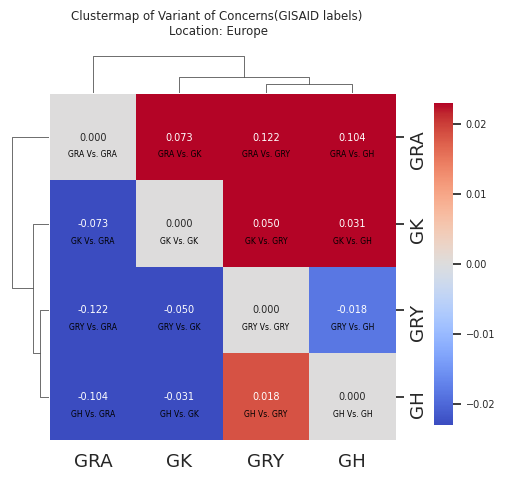

In [21]:
gry_gh_eu = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_2020-11_2020-12_gisaid_dist_mat.csv',
    index_col=0)
gh_gk_eu = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_2021-04_2021-05_gisaid_dist_mat.csv',
    index_col= 0)
gk_gra_eu = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_2021-11_2021-12_gisaid_dist_mat.csv',
    index_col=0)

clustermap_obj_eu = heatmaps_from_combined_dist_map(['GH', 'GRY', 'GK', 'GRA'],
                                                    gry_gh_eu,
                                                    gh_gk_eu,
                                                    gk_gra_eu,
                                                    'Europe')
combined_distance_matrix_eu = pd.DataFrame(clustermap_obj_eu.data)

## Asia

In [22]:
#create the seperate distance matrices for pairs
# #automation function finds the diatance matrix
automation_mine('Asia', df_weekly_sum, start = '2020-11', end = '2021-01', variant_choice_set= {'GRY', 'GH'})
# #automation function finds the diatance matrix
automation_mine('Asia', df_weekly_sum, start = '2021-02', end = '2021-04', variant_choice_set= {'GH', 'GK'})
# #automation function finds the diatance matrix
automation_mine('Asia', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'GK', 'GRA'})

Vaiants available at Asia : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2020-11', '2020-12', '2021-01']
Diatance matrix: 
           GRY        GH
GRY  0.000000  0.033296
GH   0.033296  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Asia_2020-11_2021-01_gisaid_dist_mat.csv
Vaiants available at Asia : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2021-02', '2021-03', '2021-04']
Diatance matrix: 
           GH        GK
GH  0.000000  0.016285
GK  0.016285  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Asia_2021-02_2021-04_gisaid_dist_mat.csv
Vaiants available at Asia : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2021-11', '2021-12']
Diatance matrix: 
           GK      GRA
GK   0.00000  0.04255
GRA  0.04255  0.00000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Asia_2021-11_2021-12_gisaid_dist_mat.csv


Distance Matrix :
           GRY        GH        GK       GRA
GRY  0.000000  0.033296  0.049581  0.092131
GH   0.033296  0.000000  0.016285  0.058835
GK   0.049581  0.016285  0.000000  0.042550
GRA  0.092131  0.058835  0.042550  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Asia_continent_combined_distance_matrix_for_gisaid_labels.csv
difference matrix :
           GRY        GH        GK       GRA
GRY  0.000000 -0.033296 -0.049581 -0.092131
GH   0.033296  0.000000 -0.016285 -0.058835
GK   0.049581  0.016285  0.000000 -0.042550
GRA  0.092131  0.058835  0.042550  0.000000


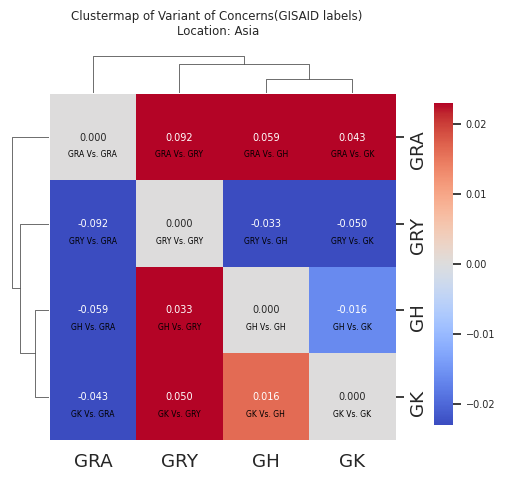

In [23]:
#turn into pandas df and create the combined heatmap
gry_gh_as = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Asia_2020-11_2021-01_gisaid_dist_mat.csv',
    index_col=0)
gh_gk_as = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Asia_2021-02_2021-04_gisaid_dist_mat.csv',
    index_col= 0)
gk_gra_as = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Asia_2021-11_2021-12_gisaid_dist_mat.csv',
    index_col=0)

clustermap_obj_as = heatmaps_from_combined_dist_map(['GH', 'GRY', 'GK', 'GRA'],
                                                    gry_gh_as,
                                                    gh_gk_as,
                                                    gk_gra_as,
                                                    'Asia')
combined_distance_matrix_as = pd.DataFrame(clustermap_obj_as.data)

## Africa

In [24]:
#create the seperate distance matrices for pairs
# #automation function finds the diatance matrix
automation_mine('Africa', df_weekly_sum, start = '2020-11', end = '2021-01', variant_choice_set= {'GRY', 'GH'})
# #automation function finds the diatance matrix
automation_mine('Africa', df_weekly_sum, start = '2021-05', end = '2021-06', variant_choice_set= {'GH', 'GK'})
# #automation function finds the diatance matrix
automation_mine('Africa', df_weekly_sum, start = '2021-11', end = '2021-11', variant_choice_set= {'GK', 'GRA'})

Vaiants available at Africa : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2020-11', '2020-12', '2021-01']
Diatance matrix: 
           GRY        GH
GRY  0.000000  0.037166
GH   0.037166  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Africa_2020-11_2021-01_gisaid_dist_mat.csv
Vaiants available at Africa : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2021-05', '2021-06']
Diatance matrix: 
           GH        GK
GH  0.000000  0.020354
GK  0.020354  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Africa_2021-05_2021-06_gisaid_dist_mat.csv
Vaiants available at Africa : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2021-11']
Diatance matrix: 
            GK       GRA
GK   0.000000  0.051087
GRA  0.051087  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Africa_2021-11_2021-11_gisaid_dist_mat.csv


Distance Matrix :
           GRY        GH        GK       GRA
GRY  0.000000  0.037166  0.057519  0.108606
GH   0.037166  0.000000  0.020354  0.071441
GK   0.057519  0.020354  0.000000  0.051087
GRA  0.108606  0.071441  0.051087  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Africa_continent_combined_distance_matrix_for_gisaid_labels.csv
difference matrix :
           GRY        GH        GK       GRA
GRY  0.000000 -0.037166 -0.057519 -0.108606
GH   0.037166  0.000000 -0.020354 -0.071441
GK   0.057519  0.020354  0.000000 -0.051087
GRA  0.108606  0.071441  0.051087  0.000000


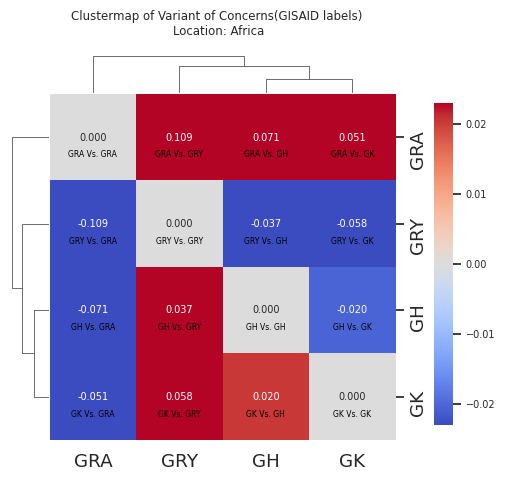

In [25]:
#turn into pandas df and create the combined heatmap
gry_gh_af = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Africa_2020-11_2021-01_gisaid_dist_mat.csv',
    index_col=0)
gh_gk_af = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Africa_2021-05_2021-06_gisaid_dist_mat.csv',
    index_col= 0)
gk_gra_af = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Africa_2021-11_2021-11_gisaid_dist_mat.csv',
    index_col=0)

clustermap_obj_af = heatmaps_from_combined_dist_map(['GH', 'GRY', 'GK', 'GRA'],
                                                    gry_gh_af,
                                                    gh_gk_af,
                                                    gk_gra_af,
                                                    'Africa')
combined_distance_matrix_af = pd.DataFrame(clustermap_obj_af.data)

## Oceania

In [26]:
#create the seperate distance matrices for pairs
# #automation function finds the diatance matrix
automation_mine('Oceania', df_weekly_sum, start = '2021-01', end = '2021-02', variant_choice_set= {'GRY', 'GH'})
# #automation function finds the diatance matrix
automation_mine('Oceania', df_weekly_sum, start = '2021-06', end = '2021-07', variant_choice_set= {'GH', 'GK'})
# #automation function finds the diatance matrix
automation_mine('Oceania', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'GK', 'GRA'})

Vaiants available at Oceania : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2021-01', '2021-02']
Diatance matrix: 
           GRY        GH
GRY  0.000000  0.000675
GH   0.000675  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Oceania_2021-01_2021-02_gisaid_dist_mat.csv
Vaiants available at Oceania : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2021-06', '2021-07']
Diatance matrix: 
           GH        GK
GH  0.000000  0.021986
GK  0.021986  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Oceania_2021-06_2021-07_gisaid_dist_mat.csv
Vaiants available at Oceania : ['GH' 'GK' 'GR' 'GRA' 'GRY']
['2021-11', '2021-12']
Diatance matrix: 
            GK       GRA
GK   0.000000  0.075895
GRA  0.075895  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Oceania_2021-11_2021-12_gisaid_dist_mat.csv


Distance Matrix :
           GRY        GH        GK       GRA
GRY  0.000000  0.000675  0.022661  0.098555
GH   0.000675  0.000000  0.021986  0.097880
GK   0.022661  0.021986  0.000000  0.075895
GRA  0.098555  0.097880  0.075895  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Oceania_continent_combined_distance_matrix_for_gisaid_labels.csv
difference matrix :
           GRY        GH        GK       GRA
GRY  0.000000 -0.000675 -0.022661 -0.098555
GH   0.000675  0.000000 -0.021986 -0.097880
GK   0.022661  0.021986  0.000000 -0.075895
GRA  0.098555  0.097880  0.075895  0.000000


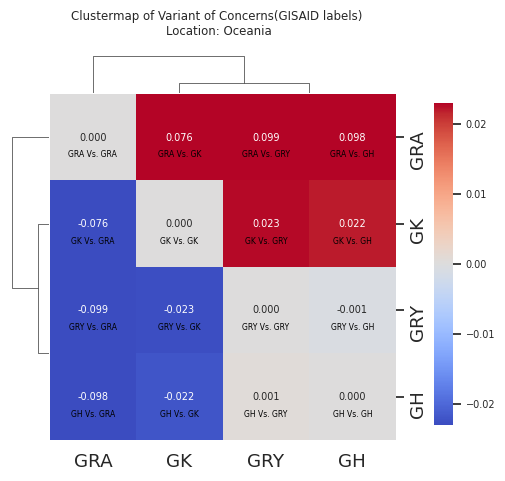

In [27]:
#turn into pandas df and create the combined heatmap
gry_gh_oc = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Oceania_2021-01_2021-02_gisaid_dist_mat.csv',
    index_col=0)
gh_gk_oc = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Oceania_2021-06_2021-07_gisaid_dist_mat.csv',
    index_col= 0)
gk_gra_oc = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Oceania_2021-11_2021-12_gisaid_dist_mat.csv',
    index_col=0)

clustermap_obj_oc = heatmaps_from_combined_dist_map(['GH', 'GRY', 'GK', 'GRA'],
                                                    gry_gh_oc,
                                                    gh_gk_oc,
                                                    gk_gra_oc,
                                                    'Oceania')
combined_distance_matrix_oc = pd.DataFrame(clustermap_obj_oc.data)